# Computing the Structure Factor for a Molecular Dynamics Trajectory of Water

The structure factor describes the local structural characteristics in the distribution of atoms in the system. A formula is provided in J. Am. Chem. Soc. 2020, 142, 2868−2875.

For a set of $N$ atoms, the structure factor is a function of wave number $k$ given by

$$S(k)=1 + \frac{1}{N}\sum_{i=1}^{N} \sum_{j\ne i}^{N} \frac{\sin(k r_{ij})}{k r_{ij}} W(r_{ij})$$

where $W(r_{ij}) = \frac{\sin(\pi r_{ij}/r_c)}{\pi r_{ij}/r_c}$. $r_c$ is a cut-off distance.

In the last set of script (v1.0), we tried to develop the code to implement the calculation of structure factor.

Here, we try to interface the structure factor with the classification results from Akanksha.

### Preparation: Installation of Required Packages
1. Install `conda colab`

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


2. Install `mdtraj` package

In [2]:
!conda install -c conda-forge mdtraj

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mdtraj


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.6               |       he440d0b_1          47 KB  conda-forge
    c-blosc2-2.16.0            |       h3122c55_0         335 KB  conda-forge
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB  conda-forge
    certifi-2026.1.4           |     pyhd8ed1ab_0         147 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    hdf5-1.14.3                |nompi_h2d575fe_109         3.7 MB  conda-forge
    libaec-1.1.5               |       h088129d_0          36 KB  conda-forge
    libblas-3.9.0              |31_h59b9bed_openblas          16 KB  conda-forge
    libcblas-3.9.0             |31_he106b

**bold text**## The Code for Computing Structure Factors

#### Import packages, Water Data

In [3]:
import numpy as np
import itertools
from matplotlib.pyplot import plot

In [4]:
import sys, site, subprocess

print("Kernel Python:", sys.executable)
print("site-packages on sys.path:", [p for p in sys.path if "site-packages" in p])

def ensure_mdtraj():
    # 1) Try normal import
    try:
        import mdtraj as md
        print("mdtraj OK:", md.__version__)
        return md
    except ModuleNotFoundError:
        pass

    # 2) Add common site-packages path where pip said it installed
    candidates = ["/usr/local/lib/python{}.{}".format(sys.version_info.major, sys.version_info.minor) + "/site-packages"]
    # also consider the user site
    try:
        candidates.append(site.getusersitepackages())
    except Exception:
        pass

    for p in candidates:
        if p and p not in sys.path:
            sys.path.insert(0, p)

    try:
        import mdtraj as md
        print("mdtraj OK after sys.path fix:", md.__version__)
        return md
    except ModuleNotFoundError:
        pass

    # 3) Force-install into THIS kernel
    print("Installing mdtraj into this kernel…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", "--force-reinstall", "mdtraj==1.11.0"])
    import mdtraj as md
    print("mdtraj OK after install:", md.__version__)
    return md

md = ensure_mdtraj()


Kernel Python: /usr/bin/python3
site-packages on sys.path: ['/root/.local/lib/python3.12/site-packages', '/usr/local/lib/python3.12/site-packages']
mdtraj OK: 1.11.0


#### Change working directory

As we will be working with a data file, we need to change the working directory to where the file is.

(1) We mount our google drive folder.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(2) We change the working directory into where the input file is

In [9]:
%cd /content/drive/MyDrive/Shared_Drive/01_Water/102_WaterMLClustering


/content/drive/Shareddrives/HMC_FLUID_Group/01_Water/102_WaterMLClustering


In [10]:
!pwd

/content/drive/Shareddrives/HMC_FLUID_Group/01_Water/102_WaterMLClustering


#### Load the trajectory and topology files

In [11]:
!ls /content/drive/.shortcut-targets-by-id/1QpmGRuNtR4n8skf4J-5Fv_kbQ6Ymc84I/01_Water/102_WaterMLClustering/Akanksha_Thesis2023/Code/cluster

 cluster.ipynb
 cluster.py
 OrderParam_Run21_swm4ndp_T30.0.mat
 OrderParam_Run21_swm4ndp_T30.0_output.csv
 OrderParam_Run22_swm4ndp_T30.0.mat
 OrderParam_Run22_swm4ndp_T30.0_output.csv
 OrderParam_Run23_swm4ndp_T30.0.mat
 OrderParam_Run23_swm4ndp_T30.0_output.csv
 OrderParamZeta_Run21_swm4ndp_T30.0.mat
 OrderParamZeta_Run22_swm4ndp_T30.0.mat
 OrderParamZeta_Run23_swm4ndp_T30.0.mat
'sample_code_to_run (1).gdoc'
 sample_code_to_run.gdoc
 sample_code_to_run.txt


In [42]:
SimulationFileDirectory = "/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/"

import glob
dcdList = glob.glob(SimulationFileDirectory + "/dcd_" + "Run23" + "_swm4ndp_T-30.0_0"+'*.dcd')
dcdList = np.sort(dcdList)
print(dcdList)
topFile = SimulationFileDirectory + "inistate_"+"Run23"+"_swm4ndp_T-30.0.pdb"
print(topFile)

['/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/dcd_Run23_swm4ndp_T-30.0_0.dcd']
/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/inistate_Run23_swm4ndp_T-30.0.pdb


In [43]:
SimulationFileDirectory = "/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/"
dcd_path = SimulationFileDirectory+ "/dcd_" + "Run23" + "_swm4ndp_T-30.0_0"+'*.dcd'
top_path = SimulationFileDirectory+"inistate_"+"Run23"+"_swm4ndp_T-30.0.pdb"


In [44]:
# loading one single file
# dcdFile = dcdList[0]
# traj = md.load_dcd(dcdFile, top=topFile)
# loading multiple trajectories

traj_dcdList = [md.load_dcd(d, top=topFile) for d in dcdList]
traj = md.join(traj_dcdList)
print(traj)
topology = traj.topology

<mdtraj.Trajectory with 1000 frames, 5120 atoms, 1024 residues, and unitcells>


In [45]:
atom_name_to_consider = 'O'
atom_to_consider_indices = [ i  for i in range(topology.n_atoms) if topology.atom(i).name == atom_name_to_consider]
traj_O_md= traj.atom_slice(atom_to_consider_indices)
coords_O = traj_O_md.xyz[:20]

In [46]:
traj.unitcell_lengths[0][0]

np.float32(3.1459105)

In [47]:
Lx, Ly, Lz = traj.unitcell_lengths[0] #length unit in x,y,z direction
angles = traj.unitcell_angles[0]   # (alpha, beta, gamma) in degrees
print("frame 0 box (nm):", Lx, Ly, Lz, "angles:", angles)

frame 0 box (nm): 3.1459105 3.1459105 3.1459105 angles: [90. 90. 90.]


In [48]:
import numpy as np

L = traj.unitcell_lengths  # shape: (n_frames, 3), nm
A = traj.unitcell_angles   # shape: (n_frames, 3), degrees

print("box constant across frames?", np.allclose(L, L[0]))
print("angles constant (orthorhombic if ~90°)?", np.allclose(A, A[0]))
print("box at first frame (nm):", L[0])

box constant across frames? True
angles constant (orthorhombic if ~90°)? True
box at first frame (nm): [3.1459105 3.1459105 3.1459105]


## Coding the function to calculate the structure factor


Debye's Structure Factor
$$S(k)=1 + \frac{1}{N}\sum_{i=1}^{N} \sum_{j\ne i}^{N} \frac{\sin(k r_{ij})}{k r_{ij}} W(r_{ij})$$


In [14]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def load_trajectory(filename):
    traj = md.load(filename)
    return traj

In [51]:
def Si_debye(k_vals, traj, r_c=0.26, max_frames=None):
    N = traj.n_atoms
    n_frames = traj.n_frames if max_frames is None else min(max_frames, traj.n_frames)

    # Reshape k_vals for broadcasting
    k_vals_vec = np.asarray(k_vals).reshape(-1, 1)  # (n_k, 1)

    # Initialize
    Sk = np.zeros(len(k_vals), dtype=np.float64)

    # Precompute pairs
    pairs = [(i, j) for i in range(N) for j in range(i+1, N)]

    # Process frames
    for frame_idx in range(n_frames):
        # Get distances (n_pairs,)
        r_ij = md.compute_distances(traj[frame_idx], atom_pairs=pairs).flatten()

        # Window function: W(r) = sin(πr/r_c) / (πr/r_c)
        arg = np.pi * r_ij / r_c
        with np.errstate(divide='ignore', invalid='ignore'):
            W_ij = np.sin(arg) / arg
            W_ij = np.where(np.abs(arg) < 1e-10, 1.0, W_ij)

        # Compute k*r
        kr = k_vals_vec * r_ij

        # Compute sin(kr)/(kr)
        with np.errstate(divide='ignore', invalid='ignore'):
            sinc_kr = np.sin(kr) / kr
            sinc_kr = np.where(np.abs(kr) < 1e-10, 1.0, sinc_kr)

        # Sum over pairs: (n_k, n_pairs) * (n_pairs,) → sum → (n_k,)
        Sk += (sinc_kr * W_ij).sum(axis=1)

    # Normalize
    Sk = 1.0 + (2.0 / N) * Sk.flatten() / n_frames
    return Sk

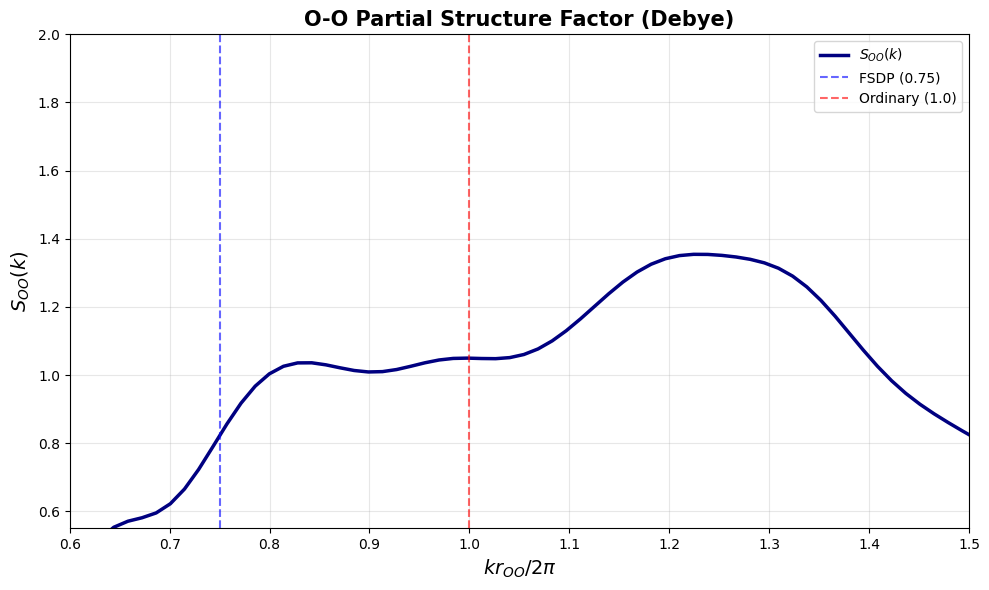

In [58]:
k_vals = np.linspace(0.5, 50, 150)
Sk = Si_debye(k_vals, traj_O_md, r_c=1.2, max_frames=20)
k_scaled = k_vals * 0.26769853 / (2 * np.pi)

plt.figure(figsize=(10, 6))
plt.plot(k_scaled, Sk, linewidth=2.5, color='navy', label='$S_{OO}(k)$')
plt.axvline(0.75, color='blue', linestyle='--', alpha=0.6, label='FSDP (0.75)')
plt.axvline(1.0, color='red', linestyle='--', alpha=0.6, label='Ordinary (1.0)')
plt.xlabel(r'$kr_{OO}/2\pi$', fontsize=14, fontweight='bold')
plt.ylabel(r'$S_{OO}(k)$', fontsize=14, fontweight='bold')
plt.title('O-O Partial Structure Factor (Debye)', fontsize=15, fontweight='bold')
plt.xlim(0.6, 1.5)
plt.ylim(0.55, 2)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Global Strucuture Factor:
$$S(k)= \frac{1}{N}<|\rho(k)|^2>$$

In [53]:
def _sphere_directions(m=96):
    """Quasi-uniform directions on the unit sphere (Fibonacci)."""
    i = np.arange(m) + 0.5
    phi = 2*np.pi * (i / ((1 + np.sqrt(5)) / 2))
    z = 1 - 2*i/m
    r = np.sqrt(np.maximum(0.0, 1 - z*z))
    return np.stack([r*np.cos(phi), r*np.sin(phi), z], axis=1)

In [54]:
def Si_reciprocal(k_vals, i, f, traj_or_coords, num_dirs=96, center=True):

    # Get coords as (T,N,3)
    if hasattr(traj_or_coords, "xyz"):              # mdtraj.Trajectory
        coords = np.asarray(traj_or_coords.xyz, dtype=float)
    else:
        coords = np.asarray(traj_or_coords, dtype=float)
        if coords.ndim == 2 and coords.shape[1] == 3:  # single frame
            coords = coords[None, ...]
        if coords.ndim != 3 or coords.shape[2] != 3:
            raise ValueError("coords must be (T,N,3) or (N,3)")

    T = coords.shape[0]
    # Slice frames; if slice is empty (e.g., single frame), fall back to all
    if isinstance(i, int) and isinstance(f, int) and 0 <= i < f <= T:
        frames = coords[i:f]
    else:
        frames = coords

    if frames.size == 0:
        frames = coords

    N = frames.shape[1]
    dirs = _sphere_directions(num_dirs)  # (D,3)

    Sk = np.zeros(len(k_vals), dtype=float)
    for frame in frames:
        R = frame - frame.mean(axis=0, keepdims=True) if center else frame  # (N,3)
        # For each k, average |rho(k)|^2 over directions
        for idx, k in enumerate(k_vals):
            q = k * dirs                      # (D,3)
            phase = R @ q.T                   # (N,D)
            rho = np.exp(-1j*phase).sum(axis=0)  # (D,)
            Sk[idx] += (np.abs(rho)**2).mean() / N

    Sk /= frames.shape[0]
    return Sk

computation complete


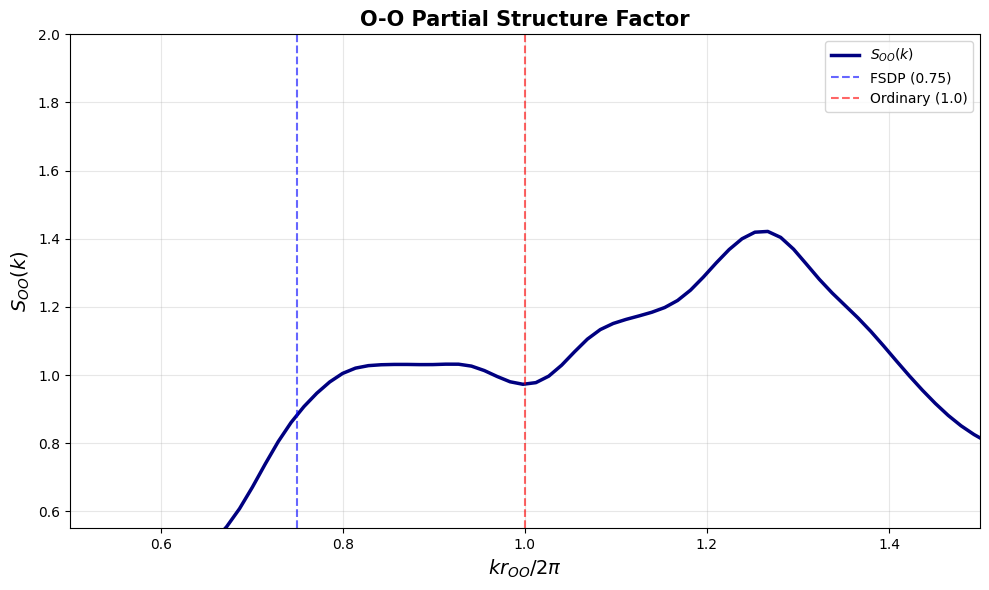

In [59]:
k_vals = np.linspace(0.5, 50, 150)
Sk = Si_reciprocal(k_vals,10, 100, traj_O_md)
print('computation complete')
k_scaled = k_vals * 0.26769853 / (2 * np.pi)

plt.figure(figsize=(10, 6))
plt.plot(k_scaled, Sk, linewidth=2.5, color='navy', label='$S_{OO}(k)$')
plt.axvline(0.75, color='blue', linestyle='--', alpha=0.6, label='FSDP (0.75)')
plt.axvline(1.0, color='red', linestyle='--', alpha=0.6, label='Ordinary (1.0)')
plt.xlabel(r'$kr_{OO}/2\pi$', fontsize=14, fontweight='bold')
plt.ylabel(r'$S_{OO}(k)$', fontsize=14, fontweight='bold')
plt.title('O-O Partial Structure Factor', fontsize=15, fontweight='bold')
plt.xlim(0.5,1.5)
plt.ylim(0.55, 2)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Try to plot the average structure factors for a range of frames.

In [19]:
k_vals = np.linspace(0.01, 60, 100)
sk_avg = Si_reciprocal(k_vals, 0, traj_O_md.n_frames-1, traj_O_md)
r_oo = 0.26769853
k_scaled = k_vals * r_oo/2/np.pi

In [ ]:
import sys, subprocess

print("Kernel:", sys.executable)
print("Python:", sys.version)

# 1) Keep only this Python's site-packages on sys.path (drop any 3.11 leftovers)
import sys as _sys
_sys.path = [p for p in _sys.path if "python3.11" not in p]

# 2) Install mutually compatible wheels into THIS kernel
# SciPy 1.14.1 + NumPy 2.0.2 is a stable, compatible pair for Py3.12
subprocess.check_call([sys.executable, "-m", "pip", "install",
                       "--no-cache-dir", "--force-reinstall",
                       "numpy==2.0.2", "scipy==1.14.1"])

# 3) Verify
import numpy, scipy
print("NumPy:", numpy.__version__, "SciPy:", scipy.__version__)

from scipy.io import loadmat
print("scipy.io.loadmat import OK")

Kernel: /usr/bin/python3.real
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2 SciPy: 1.14.1
scipy.io.loadmat import OK


## Finding the structure factor from water clusters

In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import sys

In [4]:
%cd /content/drive/MyDrive/Shared_Drive/01_Water/102_WaterMLClustering/Diya

/content/drive/Shareddrives/HMC_FLUID_Group/01_Water/102_WaterMLClustering/Diya


In [5]:
# import mat data
if len(sys.argv) > 1 and '--csv' in sys.argv:
  csv_file = sys.argv[sys.argv.index('--csv') + 1]
  print(f"Reading CSV file: {csv_file}")
  df = pd.read_csv(csv_file)
  required_cols = ['q_all', 'Q6_all', 'LSI_all', 'Sk_all', 'zeta_all']
  df = df[required_cols]

else:
    print("Loading data from .mat files...")
    from scipy.io import loadmat
    water = loadmat('OrderParam_Run21_swm4ndp_T-20.0.mat')
    water1 = loadmat('OrderParamZeta_Run21_swm4ndp_T-20.0.mat')

    q_all = []
    for i in range(0, 20):
        q_all.extend(water['q_all'][i])

    Q6_all = []
    for i in range(0, 20):
        Q6_all.extend(water['Q6_all'][i])

    LSI_all = []
    for i in range(0, 20):
        LSI_all.extend(water['LSI_all'][i])

    Sk_all = []
    for i in range(0, 20):
        Sk_all.extend(water['Sk_all'][i])

    zeta_all = []
    for i in range(0, 20):
        zeta_all.extend(water1['zeta_all'][i])

    df = pd.DataFrame({
        'q_all': q_all,
        'Q6_all': Q6_all,
        'LSI_all': LSI_all,
        'Sk_all': Sk_all,
        'zeta_all': zeta_all
    })

Loading data from .mat files...


In [7]:
scaler = preprocessing.MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#### Run DBSCAN and store the value

In [47]:
dbscan = DBSCAN(eps=0.0777, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

In [48]:
# Store DBSCAN labels in dataframe
df['dbscan_cluster'] = dbscan_labels
unique, counts = np.unique(dbscan_labels, return_counts=True)
print("DBSCAN Results:")
for label, count in zip(unique, counts):
    if label == -1:
        print(f"  Noise: {count} points")
    else:
        print(f"  Cluster {label}: {count} points")

DBSCAN Results:
  Noise: 589 points
  Cluster 0: 19865 points
  Cluster 1: 6 points
  Cluster 2: 5 points
  Cluster 3: 4 points
  Cluster 4: 7 points
  Cluster 5: 4 points


#### Run GMM and store the value

In [52]:
gmm = GaussianMixture(n_components=2, covariance_type='full',
                       random_state=10010, n_init=10, max_iter=100)
gmm.fit(df_scaled)
gmm_labels = gmm.predict(df_scaled)
gmm_probs = gmm.predict_proba(df_scaled)

In [58]:
df['gmm_cluster'] = gmm_labels
df['gmm_prob_0'] = gmm_probs[:, 0]
df['gmm_prob_1'] = gmm_probs[:, 1]
df['gmm_confidence'] = gmm_probs.max(axis=1)

Quick Plotting

In [60]:
cluster_0 = df[df['gmm_cluster'] == 0]
cluster_1 = df[df['gmm_cluster'] == 1]


print(f"Cluster 0: {len(cluster_0)} points")
print(f"Cluster 1: {len(cluster_1)} points")

Cluster 0: 8256 points
Cluster 1: 12224 points


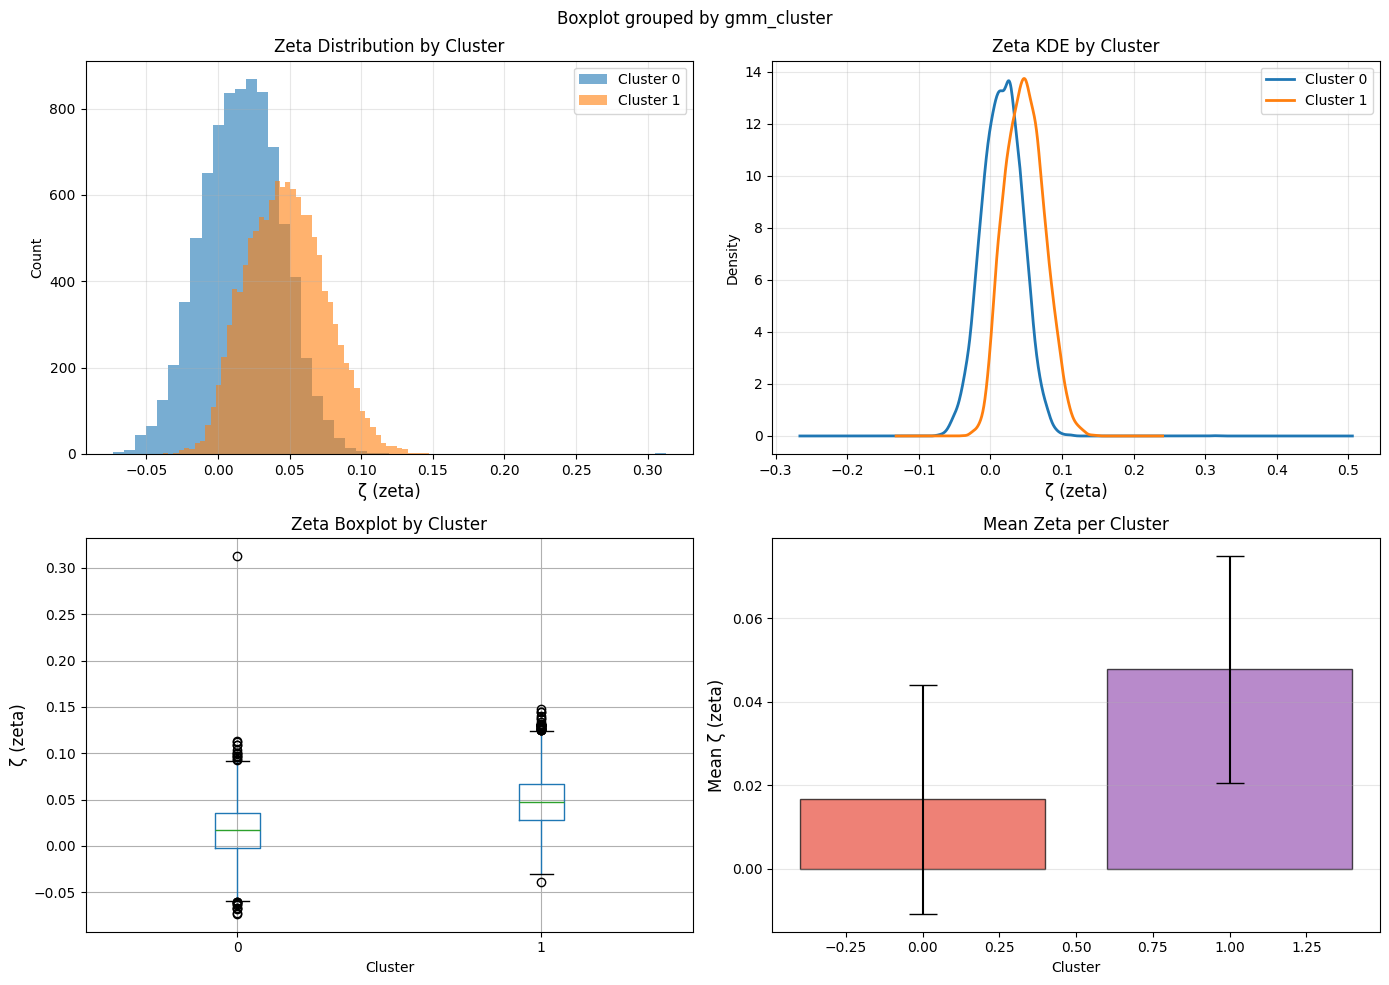


Zeta statistics by cluster:
               count      mean       std       min       25%       50%  \
gmm_cluster                                                              
0             8256.0  0.016584  0.027429 -0.073240 -0.002645  0.016937   
1            12224.0  0.047699  0.027095 -0.038728  0.027636  0.046979   

                  75%       max  
gmm_cluster                      
0            0.035568  0.312551  
1            0.066349  0.147372  


In [61]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram
ax = axes[0, 0]
for cluster in [0, 1]:
    data = df[df['gmm_cluster'] == cluster]['zeta_all']
    ax.hist(data, bins=50, alpha=0.6, label=f'Cluster {cluster}')
ax.set_xlabel('ζ (zeta)', fontsize=12)
ax.set_ylabel('Count')
ax.set_title('Zeta Distribution by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: KDE (smooth distribution)
ax = axes[0, 1]
for cluster in [0, 1]:
    data = df[df['gmm_cluster'] == cluster]['zeta_all']
    data.plot(kind='kde', ax=ax, label=f'Cluster {cluster}', linewidth=2)
ax.set_xlabel('ζ (zeta)', fontsize=12)
ax.set_ylabel('Density')
ax.set_title('Zeta KDE by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Boxplot
ax = axes[1, 0]
df.boxplot(column='zeta_all', by='gmm_cluster', ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('ζ (zeta)', fontsize=12)
ax.set_title('Zeta Boxplot by Cluster')
plt.sca(ax)
plt.xticks([1, 2], ['0', '1'])

# Plot 4: Mean with error bars
ax = axes[1, 1]
means = df.groupby('gmm_cluster')['zeta_all'].mean()
stds = df.groupby('gmm_cluster')['zeta_all'].std()
colors = ['#E74C3C', '#9B59B6', '#3498DB']
ax.bar([0, 1], means.values, yerr=stds.values,
       capsize=10, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean ζ (zeta)', fontsize=12)
ax.set_title('Mean Zeta per Cluster')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("\nZeta statistics by cluster:")
print(df.groupby('gmm_cluster')['zeta_all'].describe())

Quick Identification of Cluster Type

In [62]:
cluster_stats = df.groupby('gmm_cluster').agg({
    'zeta_all': 'mean',
    'q_all': 'mean',
    'Q6_all': 'mean',
    'LSI_all': 'mean'
}).sort_values('zeta_all')

print("\nCluster ordering (low zeta → high zeta):")
print(cluster_stats)

# Assign types based on Tanaka's paper
cluster_order = cluster_stats.index.tolist()
cluster_types = {
    cluster_order[0]: 'DNLS (Disordered)',
    cluster_order[1]: 'LFTS (Tetrahedral)'
}

print("\nPhysical interpretation:")
for cluster_id, cluster_type in cluster_types.items():
    mean_zeta = cluster_stats.loc[cluster_id, 'zeta_all']
    print(f"  Cluster {cluster_id}: {cluster_type} (mean ζ = {mean_zeta:.4f})")



Cluster ordering (low zeta → high zeta):
             zeta_all     q_all    Q6_all   LSI_all
gmm_cluster                                        
0            0.016584  0.601921  0.266365  0.000240
1            0.047699  0.755543  0.267999  0.000527

Physical interpretation:
  Cluster 0: DNLS (Disordered) (mean ζ = 0.0166)
  Cluster 1: LFTS (Tetrahedral) (mean ζ = 0.0477)


In [63]:
df['cluster_type'] = df['gmm_cluster'].map(cluster_types)

In [65]:
df.drop(columns='dbscan_cluster', axis=1)

,q_all,Q6_all,LSI_all,Sk_all,zeta_all,gmm_cluster,gmm_prob_0,gmm_prob_1,gmm_confidence,cluster_type
0,0.626352,0.247660,0.000258,0.999416,0.049362,1,0.117787,0.882213,0.882213,LFTS (Tetrahedral)
1,0.509500,0.197257,0.000140,0.999416,-0.024610,0,0.926519,0.073481,0.926519,DNLS (Disordered)
2,0.828954,0.232930,0.000536,0.999829,0.037042,1,0.009310,0.990690,0.990690,LFTS (Tetrahedral)
3,0.869303,0.280603,0.000521,0.999052,0.059151,1,0.095426,0.904574,0.904574,LFTS (Tetrahedral)
4,0.592149,0.242927,0.000181,0.998936,0.042647,0,0.870355,0.129645,0.870355,DNLS (Disordered)
...,...,...,...,...,...,...,...,...,...,...
20475,0.879870,0.232809,0.000202,0.998329,0.048572,0,0.999892,0.000108,0.999892,DNLS (Disordered)
20476,0.487201,0.200648,0.000131,0.998958,-0.019083,0,0.991167,0.008833,0.991167,DNLS (Disordered)
20477,0.858270,0.351036,0.000211,0.998734,0.034057,0,0.963013,0.036987,0.963013,DNLS (Disordered)
20478,0.794794,0.345696,0.000768,0.999530,0.042252,1,0.000335,0.999665,0.999665,LFTS (Tetrahedral)


### Compute Sk by cluster

In [67]:
SimulationFileDirectory = "/content/drive/MyDrive/Shared_Drive/01_Water/WaterData/SimulationData_1024Molecules_supercooled_swm4ndp/SimulationData_1024Molecules_supercooled_swm4ndp/"

import glob
dcdList = glob.glob(SimulationFileDirectory + "/dcd_" + "Run23" + "_swm4ndp_T-30.0_0" + '*.dcd')
dcdList = np.sort(dcdList)
topFile = SimulationFileDirectory + "inistate_" + "Run23" + "_swm4ndp_T-30.0.pdb"

# Load trajectory
traj_dcdList = [md.load_dcd(d, top=topFile) for d in dcdList]
traj = md.join(traj_dcdList)

# Extract only oxygen atoms
oxygen_indices = traj.topology.select('name O')
traj_O_md = traj.atom_slice(oxygen_indices)

In [68]:
# load labels from df
gmm_labels = df['gmm_cluster'].values

In [70]:
# Reshape the data structure to match the data
n_frames = traj_O_md.n_frames
n_atoms = traj_O_md.n_atoms

# Reshape labels back to (frames, atoms)
if len(gmm_labels) == n_frames * n_atoms:
    cluster_labels_2d = gmm_labels.reshape(n_frames, n_atoms)
    print(f"Reshaped labels to ({n_frames}, {n_atoms})")
else:
    print(f"Warning: Label count mismatch!")
    print(f"Expected: {n_frames * n_atoms}, Got: {len(gmm_labels)}")
    # Try to handle mismatch
    if len(gmm_labels) > n_frames * n_atoms:
        cluster_labels_2d = gmm_labels[:n_frames * n_atoms].reshape(n_frames, n_atoms)
    else:
        print("   Cannot proceed - need to check data alignment!")

⚠ Warning: Label count mismatch!
   Expected: 1024000, Got: 20480
   Cannot proceed - need to check data alignment!
